In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
import solarcell
import numpy
from matplotlib import pyplot as plt

In [3]:
# Azur Space 3G30A triple-junction solar cells in a 24s12p configuration.
# Isc/Imp are specified in (A, A/C), Voc/Vmp are specified in (V, V/C).
# Temperature is specified in C. Intensity is unitless and scales Isc/Imp.
array = solarcell.array(
    isc=(0.5196, 0.00036),  # short-circuit current, temp coefficient
    voc=(2.690, -0.0062),  # open-circuit voltage, temp coefficient
    imp=(0.5029, 0.00024),  # max-power current, temp coefficient
    vmp=(2.409, -0.0067),  # max-power voltage, temp coefficient
    t=28,  # temperature at which the above parameters are specified
    ns=24,  # number of series cells in a string
    np=12,  # number of parallel strings in an array
)

In [27]:
curve = array.curve(t=[80, 80, 80, 80, 80, 80, 40, 40, 40, 40, 40, 40], g=1)

In [28]:
curve.isc, curve.voc, curve.imp, curve.vmp, curve.pmp

(6.373196244574505,
 62.7779835699461,
 6.174835768158772,
 50.39834116426103,
 311.20147967694766)

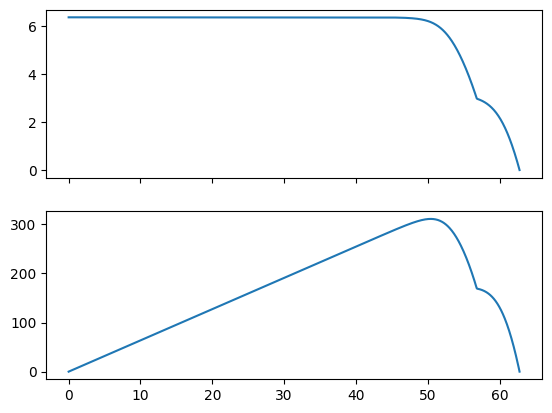

In [29]:
v = numpy.linspace(0, curve.voc, 1000)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(v, curve.iv(v))
ax1.plot(v, curve.pv(v))

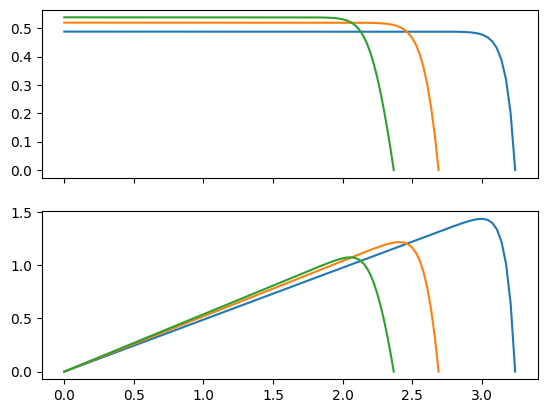

In [30]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)

for t in [-60, 28, 80]:
    cell = array.cell(t=t, g=1)
    v = numpy.linspace(0, cell.voc, 100)
    ax0.plot(v, cell.iv(v))
    ax1.plot(v, cell.pv(v))